# Normalization and batch correction

## Settings

#Path related settings (these should be the same as for the previous notebook)
output_dir = '/home/rstudio/processed_data'
test = 'cropped_146'

In [177]:
# Path related settings (these should be the same as for the previous notebook)
output_dir = '/mnt/workspace/jdetlef/processed_data'
test = 'Esophagus'

In [178]:
# choose normalization method. If None, two normalization methods will be 
# performed and visualized with pca plot
norm_method=None  # can be 'tfidf' or 'total'
log_normalize=True

# Options for highly variable genes
min_score = None

# batch correction: If True, several batch correction methods will be performed,
# you can choose the best one after
batch_column = "batch"
perform_batch_correction = True
batch_methods = ["bbknn", "mnn", "harmony", "scanorama"]

# save figures
save_figs = False

## Loading packages and setup

In [179]:
# sctoolbox modules
import sctoolbox.atac_tree as sub_tree
import sctoolbox.creators as cr
import sctoolbox.annotation as an
from sctoolbox.qc_filter import *
import sctoolbox.plotting as pl
from sctoolbox.atac_utils import *
from sctoolbox.analyser import *
import sctoolbox.atac as atac
# import episcanpy
import scanpy as sc
import episcanpy as epi
#from episcanpy.preprocessing import _decomposition
import numpy as np

## Setup path handling object 

In [180]:
# make an instance of the class
tree = sub_tree.ATAC_tree()
# set processing/output directory
tree.processing_dir = output_dir
# set sample/experiment.. 
tree.run = test

all directories existing
all directories existing


## Load anndata 

In [181]:
# probably updated in future
qc_output = tree.qc_anndata  # path to qc_adata should be here
adata = epi.read_h5ad(qc_output)
adata

AnnData object with n_obs × n_vars = 15166 × 144751
    obs: 'TN', 'UM', 'PP', 'UQ', 'CM', 'file', 'sample', 'n_features_by_counts', 'log1p_n_features_by_counts', 'total_counts', 'log1p_total_counts', 'insertsize_count', 'mean_insertsize', 'n_total_fragments', 'n_fragments_in_promoters', 'pct_fragments_in_promoters', 'nb_features', 'log_nb_features'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    uns: 'color_set', 'infoprocess', 'insertsize_distribution', 'legend'
    layers: 'binary'

## Find highly variable features

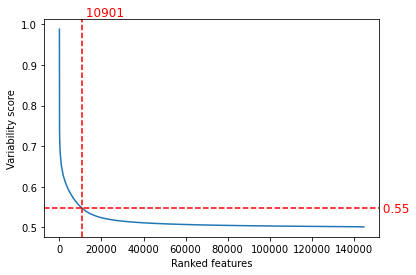

In [182]:
atac.get_variable_features(adata, min_score, show=True, inplace=True)

In [183]:
#Number of variable genes selected
adata.var["highly_variable"].sum()

10901

## Normalization

In [184]:
# Consider using parts of sctoolbox.analyser

In [185]:
if norm_method == 'tfidf':
    epi.pp.tfidf(adata, norm='l1', layer_tfidf_key='tf-idf')
if norm_method == 'total':
    sc.pp.normalize_total(adata)
    adata.layers['normalised'] = adata.X.copy()
#if not norm_method:
#    atac_norm(adata)  #a function that performs both norm methods and pca for each method, then plots so the user can choose

In [186]:
if log_normalize:
    epi.pp.log1p(adata)

## PCA

In [187]:
sc.pp.pca(adata, svd_solver='arpack', n_comps=50, use_highly_variable=True)

## Calc Neighbours

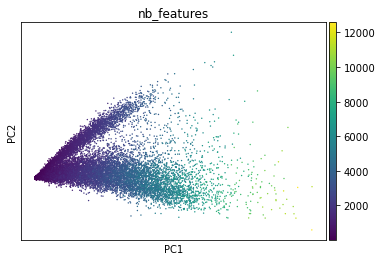

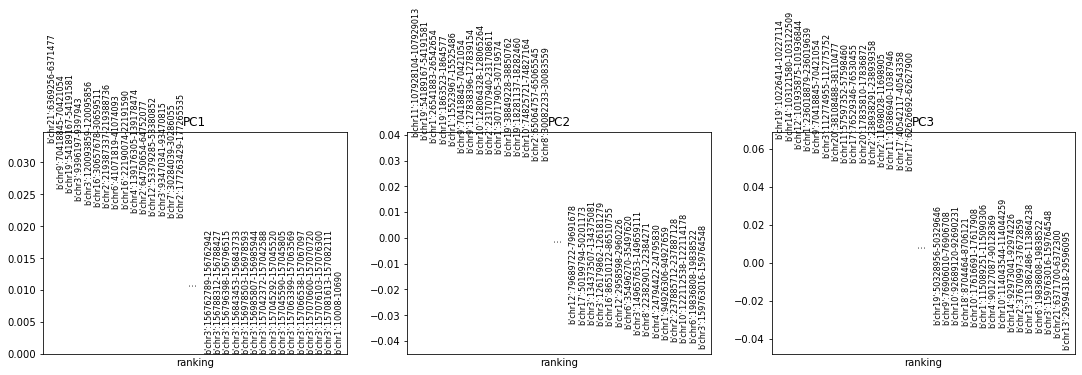

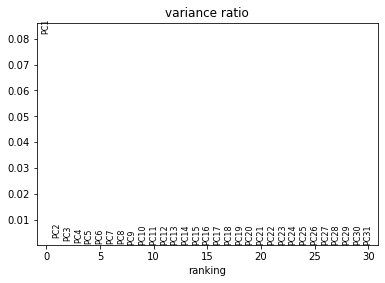

In [188]:
# Change to module
if save_figs:
    epi.pl.pca_overview(adata, color=['nb_features'], show=False)
    #plt.savefig(f'{OUTPUT_FIGS}/pca_nb_features.png')
    plt.show()
else:
    epi.pl.pca_overview(adata, color=['nb_features'])

In [189]:
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50, method='umap', metric='euclidean')

## UMAP

Computing UMAPs:   0%|          | 0/8 [00:00<?, ?it/s]

Plotting umap for spread=2.0 and dist=0.1 (1/8)
Plotting umap for spread=2.0 and dist=0.2 (2/8)
Plotting umap for spread=2.0 and dist=0.3 (3/8)
Plotting umap for spread=2.0 and dist=0.4 (4/8)
Plotting umap for spread=2.5 and dist=0.1 (5/8)
Plotting umap for spread=2.5 and dist=0.2 (6/8)
Plotting umap for spread=2.5 and dist=0.3 (7/8)
Plotting umap for spread=2.5 and dist=0.4 (8/8)


array([[<AxesSubplot:title={'center':'min_dist: 0.1'}, ylabel='spread: 2.0'>,
        <AxesSubplot:title={'center':'min_dist: 0.2'}>,
        <AxesSubplot:title={'center':'min_dist: 0.3'}>,
        <AxesSubplot:title={'center':'min_dist: 0.4'}>],
       [<AxesSubplot:ylabel='spread: 2.5'>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

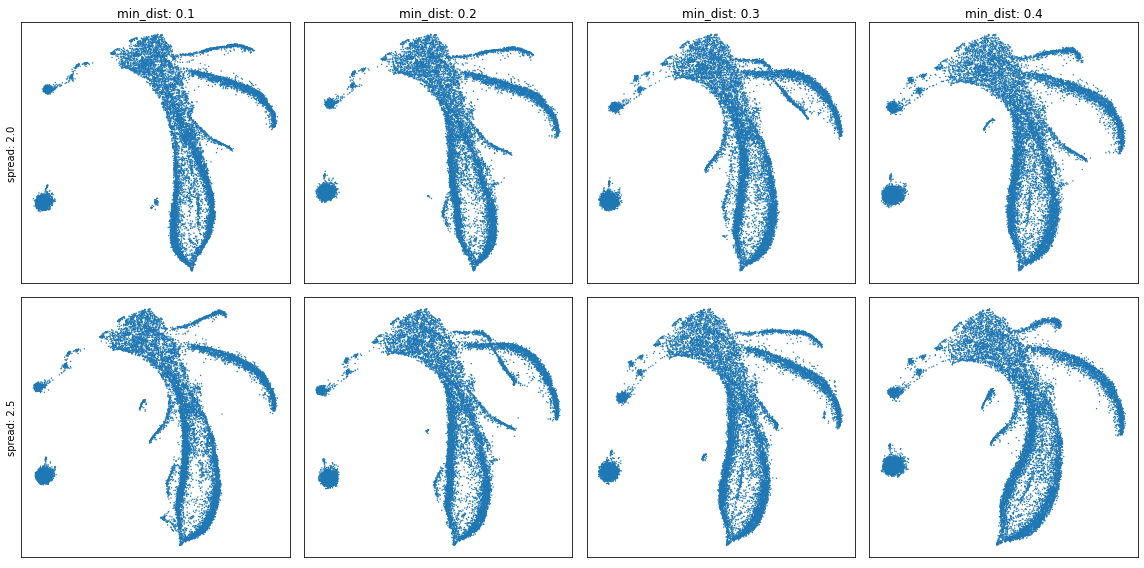

In [190]:
pl.search_umap_parameters(adata, 
                       dist_range=(0.1, 0.4, 0.1), 
                       spread_range=(2.0, 3.0, 0.5), 
                       metacol='sample', 
                       n_components=2, 
                       verbose=True, 
                       threads=4, 
                       save=None)

## Batch correction

In [76]:
adata.obs['batch'] = 1

In [77]:
adata.obs['batch']

barcode
AAACTACCAGAAACGTCCCGTT    1
AAACTACCAGAACGACTGCTCG    1
AAACTACCAGAACTAACGTCGA    1
AAACTACCAGAAGCCCATTGCC    1
AAACTACCAGAAGCGCCATCGA    1
                         ..
TTCCATCCTCTTCTCATGGTCA    1
TTCCATCCTCTTGACAAGTCCT    1
TTCCATCCTCTTGAGCCCGGAT    1
TTCCATCCTCTTGCATGTACGC    1
TTCCATCCTCTTGGCTGTCTGT    1
Name: batch, Length: 15169, dtype: int64

In [78]:
adata.obs[batch_column] = adata.obs[batch_column].astype("category") #ensure that batch column is a category

In [79]:
if perform_batch_correction:
    batch_corrections = analyser.wrap_corrections(adata, 
                                              batch_key=batch_column,
                                              methods=batch_methods)
else:
    batch_corrections = {"uncorrected": adata}

Running batch correction with 'bbknn'...
Running batch correction with 'mnn'...
Running batch correction with 'harmony'...
Running batch correction with 'scanorama'...
Finished batch correction(s)!


In [80]:
#Run standard umap for all adatas
analyser.wrap_umap(batch_corrections.values(), threads=threads)

NameError: name 'threads' is not defined

In [ ]:
# Should preliminary clustering be performed?
do_clustering = True #True or False

In [ ]:
#Perform additional clustering if it was chosen
if do_clustering:
    for adata in batch_corrections.values():
        sc.tl.leiden(adata)
    color_by.append("leiden")

In [ ]:
# Calculate LISI scores for batch
analyser.wrap_batch_evaluation(batch_corrections, batch_key=batch_column, threads=threads, inplace=True)

In [ ]:
#Plot the overview of batch correction methods
_ = pl.anndata_overview(batch_corrections, color_by=color_by, 
                        output=figure_path + "batch_correction_overview.pdf")

## save anndata

In [191]:
adata_output = tree.norm_correction_anndata
adata.write(filename=adata_output)